# Import

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from pycox.models import CoxPH, DeepHit

from pycox.evaluation import EvalSurv
from pycox.simulations import SimStudyLinearPH

import torch
import torchtuples as tt

In [2]:
df_raw = pd.read_csv('use.csv')
df_raw = pd.DataFrame(df_raw)
df_raw.head()

,Age,Year,Race,Grade,Pathology,T,N,M,Stage,Size,...,Regional.nodes.examined,Surgery,Radiotherapy,Chemotherapy,History.Of.Malignancy,Gleason.C.,Gleason.P.,PSA,duration,event
0,82,2015,White,II,"8140/3: Adenocarcinoma, NOS",T2c,N0,M0,IIB,27,...,6,Yes,No,No,Yes,7,7,7.2,50,1
1,69,2013,White,II,"8140/3: Adenocarcinoma, NOS",T2a,N0,M0,IIA,5,...,2,Yes,No,No,Yes,6,6,12.0,82,0
2,58,2011,White,III,"8140/3: Adenocarcinoma, NOS",T3a,N0,M0,III,18,...,3,Yes,No,No,Yes,7,7,5.7,107,0
3,69,2014,White,II,"8140/3: Adenocarcinoma, NOS",T2a,N0,M0,IIA,15,...,5,Yes,No,No,Yes,6,7,3.6,64,0
4,62,2014,Other,III,"8140/3: Adenocarcinoma, NOS",T3a,N0,M0,III,19,...,6,Yes,No,No,Yes,8,9,17.2,62,0


In [4]:
# take out y
df_raw_y = df_raw[["duration","event"]]
df_raw_y.head()

,duration,event
0,50,1
1,82,0
2,107,0
3,64,0
4,62,0


In [5]:
# take out x
df_raw_x = df_raw.drop(["duration","event","Year","Size"], axis=1)
df_raw_x.head()

,Age,Race,Grade,Pathology,T,N,M,Stage,Regional.nodes.positive,Regional.nodes.examined,Surgery,Radiotherapy,Chemotherapy,History.Of.Malignancy,Gleason.C.,Gleason.P.,PSA
0,82,White,II,"8140/3: Adenocarcinoma, NOS",T2c,N0,M0,IIB,0,6,Yes,No,No,Yes,7,7,7.2
1,69,White,II,"8140/3: Adenocarcinoma, NOS",T2a,N0,M0,IIA,0,2,Yes,No,No,Yes,6,6,12.0
2,58,White,III,"8140/3: Adenocarcinoma, NOS",T3a,N0,M0,III,0,3,Yes,No,No,Yes,7,7,5.7
3,69,White,II,"8140/3: Adenocarcinoma, NOS",T2a,N0,M0,IIA,0,5,Yes,No,No,Yes,6,7,3.6
4,62,Other,III,"8140/3: Adenocarcinoma, NOS",T3a,N0,M0,III,0,6,Yes,No,No,Yes,8,9,17.2


In [6]:
# transform the categorical variables
le = LabelEncoder()
cat_list = ["Race","Grade","Pathology","T","N","M","Stage","Surgery","Radiotherapy","Chemotherapy","History.Of.Malignancy"] #list of categorical variables
for cat in cat_list:
    df_raw_x[cat] = le.fit_transform(df_raw_x[cat])
df_raw_x.head()

,Age,Race,Grade,Pathology,T,N,M,Stage,Regional.nodes.positive,Regional.nodes.examined,Surgery,Radiotherapy,Chemotherapy,History.Of.Malignancy,Gleason.C.,Gleason.P.,PSA
0,82,2,1,2,6,0,0,2,0,6,1,0,0,1,7,7,7.2
1,69,2,1,2,4,0,0,1,0,2,1,0,0,1,6,6,12.0
2,58,2,2,2,8,0,0,3,0,3,1,0,0,1,7,7,5.7
3,69,2,1,2,4,0,0,1,0,5,1,0,0,1,6,7,3.6
4,62,1,2,2,8,0,0,3,0,6,1,0,0,1,8,9,17.2


In [7]:
# split the data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=2022)
x_train.head()

,Age,Race,Grade,Pathology,T,N,M,Stage,Regional.nodes.positive,Regional.nodes.examined,Surgery,Radiotherapy,Chemotherapy,History.Of.Malignancy,Gleason.C.,Gleason.P.,PSA
3837,74,2,1,2,6,0,0,2,0,2,1,0,0,0,6,6,7.5
11328,66,2,2,2,6,0,0,2,0,7,1,0,0,0,9,7,6.5
1871,62,1,1,2,6,0,0,2,0,2,1,0,0,0,7,6,26.5
7936,65,2,1,2,4,0,0,1,0,9,1,0,0,0,6,7,1.2
14856,61,2,2,2,9,0,0,3,0,6,1,1,0,0,8,7,27.0


In [8]:
# sign group info on the raw data 
df_raw.loc[x_train.index, "Group"] = "Train"
df_raw.loc[x_test.index, "Group"] = "Test"
df_raw.head()

,Age,Year,Race,Grade,Pathology,T,N,M,Stage,Size,...,Surgery,Radiotherapy,Chemotherapy,History.Of.Malignancy,Gleason.C.,Gleason.P.,PSA,duration,event,Group
0,82,2015,White,II,"8140/3: Adenocarcinoma, NOS",T2c,N0,M0,IIB,27,...,Yes,No,No,Yes,7,7,7.2,50,1,Train
1,69,2013,White,II,"8140/3: Adenocarcinoma, NOS",T2a,N0,M0,IIA,5,...,Yes,No,No,Yes,6,6,12.0,82,0,Train
2,58,2011,White,III,"8140/3: Adenocarcinoma, NOS",T3a,N0,M0,III,18,...,Yes,No,No,Yes,7,7,5.7,107,0,Test
3,69,2014,White,II,"8140/3: Adenocarcinoma, NOS",T2a,N0,M0,IIA,15,...,Yes,No,No,Yes,6,7,3.6,64,0,Test
4,62,2014,Other,III,"8140/3: Adenocarcinoma, NOS",T3a,N0,M0,III,19,...,Yes,No,No,Yes,8,9,17.2,62,0,Test


In [9]:
df_raw_x.columns

Index(['Age', 'Race', 'Grade', 'Pathology', 'T', 'N', 'M', 'Stage',
       'Regional.nodes.positive', 'Regional.nodes.examined', 'Surgery',
       'Radiotherapy', 'Chemotherapy', 'History.Of.Malignancy', 'Gleason.C.',
       'Gleason.P.', 'PSA'],
      dtype='object')

# Conduct Net

In [10]:
cols_standardize = ["Age","Regional.nodes.positive","Regional.nodes.examined","Gleason.C.","Gleason.P.","PSA"]
cols_leave = ["Race","Grade","Pathology","T","N","M","Stage","Surgery","Radiotherapy","Chemotherapy","History.Of.Malignancy"] 

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(x_train).astype('float32')
x_test = x_mapper.transform(x_test).astype('float32')

In [11]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(y_train)
y_test = get_target(y_test)
#durations_test, events_test = get_target(y_test)
val = x_test, y_test

In [12]:
y_test

(array([ 94,  50, 111, ...,  80,  67,  96], dtype=int64),
 array([0, 1, 0, ..., 0, 0, 0], dtype=int64))

In [13]:
in_features = x_train.shape[1]
num_nodes = [256,128,64,32,32,8]
out_features = 1
batch_norm = True
dropout = 0.4
output_bias = False
batch_size = 2048


net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

model = CoxPH(net, tt.optim.Adam)
model.optimizer.set_lr(0.01)
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
verbose = True

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 8.9430,	val_loss: 7.0442
1:	[0s / 0s],		train_loss: 7.3562,	val_loss: 6.9328
2:	[0s / 0s],		train_loss: 7.2888,	val_loss: 6.9525
3:	[0s / 0s],		train_loss: 7.2877,	val_loss: 6.9435
4:	[0s / 0s],		train_loss: 7.2310,	val_loss: 6.9407
5:	[0s / 0s],		train_loss: 7.2165,	val_loss: 6.9368
6:	[0s / 1s],		train_loss: 7.1818,	val_loss: 6.9321
7:	[0s / 1s],		train_loss: 7.1528,	val_loss: 6.9228
8:	[0s / 1s],		train_loss: 7.1522,	val_loss: 6.9121
9:	[0s / 1s],		train_loss: 7.1400,	val_loss: 6.8985
10:	[0s / 1s],		train_loss: 7.1165,	val_loss: 6.8860
11:	[0s / 1s],		train_loss: 7.0838,	val_loss: 6.8757
12:	[0s / 2s],		train_loss: 7.0694,	val_loss: 6.8666
13:	[0s / 2s],		train_loss: 7.0594,	val_loss: 6.8560
14:	[0s / 2s],		train_loss: 7.0523,	val_loss: 6.8487
15:	[0s / 2s],		train_loss: 7.0669,	val_loss: 6.8444
16:	[0s / 2s],		train_loss: 7.0573,	val_loss: 6.8413
17:	[0s / 2s],		train_loss: 7.0523,	val_loss: 6.8387
18:	[0s / 3s],		train_loss: 7.0415,	val_loss: 6.8368
19:

0.6931553920610714

<Figure size 864x864 with 0 Axes>

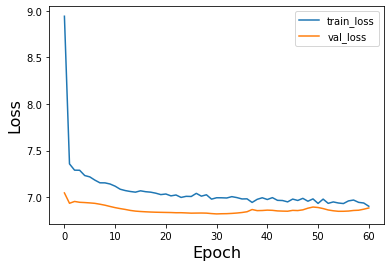

In [14]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
model.compute_baseline_hazards() #baseline hazard
surv_cox = model.predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, y_test[0], y_test[1], censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.0456522608102399

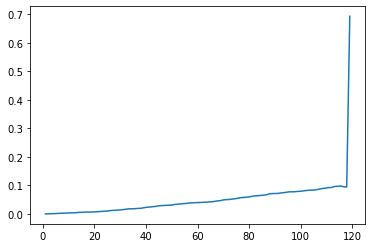

In [15]:
# integrated_brier_score at all
time_grid = np.linspace(y_test[0].min(), y_test[0].max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [16]:
# Internal c-index at  all
time_test0, status_test0 = y_train[0], y_train[1]
surv_cox0 = model.predict_surv_df(x_train) # survival of the train data
eval_cox0 = EvalSurv(surv_cox0, time_test0, status_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.7103841120537446

# Bootstrap

In [17]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
model.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 500,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.7096448724301754
The C-index High 95% CI:0.7126138361996861
The C-index Low 95% CI:0.7066759086606647


In [18]:
# External
ex_tem = []
model.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 500,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))

Bootstrap Internal validation:
The C-index:0.6925225535177485
The C-index High 95% CI:0.6954781949937683
The C-index Low 95% CI:0.6895669120417287
